# RNNs: How To Implement A Basic RNN

### Read In, Clean, And Split The Data

In [2]:
# Read in data and split into training and test set
# NOTE: we are NOT cleaning the data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', 1000)

messages = pd.read_csv('spam.csv', encoding='latin-1')
messages = messages.drop(labels = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)
messages.columns = ["label", "text"]
labels = np.where(messages['label']=='spam', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(messages['text'],
                                                    labels, test_size=0.2)

### Prep Data For Modeling

In [5]:
# Install keras
!pip install -U keras
!pip install tensorflow -U

Requirement already up-to-date: keras in /opt/conda/lib/python3.8/site-packages (2.4.3)
     |████████████████████████████████| 394.8 MB 43 kB/s  eta 0:00:01     |██▌                             | 31.2 MB 6.0 MB/s eta 0:01:01     |███▌                            | 42.6 MB 5.3 MB/s eta 0:01:07     |█████████████████               | 210.5 MB 1.6 MB/s eta 0:01:57     |██████████████████▉             | 231.7 MB 5.5 MB/s eta 0:00:30     |████████████████████            | 247.4 MB 2.6 MB/s eta 0:00:56     |█████████████████████▎          | 263.0 MB 5.2 MB/s eta 0:00:26     |██████████████████████          | 272.4 MB 5.6 MB/s eta 0:00:22     |██████████████████████▉         | 281.5 MB 6.0 MB/s eta 0:00:19     |██████████████████████████▏     | 322.9 MB 1.7 MB/s eta 0:00:42     |██████████████████████████████▏ | 372.3 MB 6.1 MB/s eta 0:00:04     |██████████████████████████████▎ | 374.0 MB 1.0 MB/s eta 0:00:21     |██████████████████████████████▊ | 379.4 MB 5.3 MB/s eta 0:00:03
     |██████████

In [6]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [10]:
# Initialize and fit the tokenizer
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_train)

In [11]:
# Use that tokenizer to transform the text messages in the training and test sets
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [12]:
# What do these sequences look like?
X_train_seq[0]

[179,
 3,
 56,
 2,
 91,
 11,
 384,
 545,
 108,
 22,
 23,
 546,
 108,
 266,
 2014,
 3771,
 8,
 5,
 197]

In [20]:
# Pad the sequences so each sequence is the same length
X_train_seq_padded= pad_sequences(X_train_seq,50)
X_test_seq_padded= pad_sequences(X_test_seq,50)

In [21]:
# What do these padded sequences look like?
X_train_seq_padded[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,  179,    3,
         56,    2,   91,   11,  384,  545,  108,   22,   23,  546,  108,
        266, 2014, 3771,    8,    5,  197], dtype=int32)

### Build Model

In [15]:
# Import the tools needed from keras and define functions to calculate recall and precision
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM
from keras.models import Sequential

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [16]:
# Construct a simple RNN model
model = Sequential()

model.add(Embedding(len(tokenizer.index_word)+1, 32))
model.add(LSTM(32, dropout=0, recurrent_dropout=0))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256160    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 265,569
Trainable params: 265,569
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', precision_m, recall_m])

In [22]:
# Fit the RNN model
history = model.fit(X_train_seq_padded, y_train, 
                    batch_size=32, epochs=10,
                    validation_data=(X_test_seq_padded, y_test))

Epoch 1/10
140/140 [==============================] - 7s 34ms/step - loss: 0.4578 - accuracy: 0.8522 - precision_m: 0.1500 - recall_m: 0.1478 - val_loss: 0.0784 - val_accuracy: 0.9785 - val_precision_m: 0.9857 - val_recall_m: 0.8564
Epoch 2/10
140/140 [==============================] - 4s 30ms/step - loss: 0.0327 - accuracy: 0.9918 - precision_m: 0.9877 - recall_m: 0.9441 - val_loss: 0.0482 - val_accuracy: 0.9857 - val_precision_m: 0.9490 - val_recall_m: 0.9515
Epoch 3/10
140/140 [==============================] - 4s 31ms/step - loss: 0.0144 - accuracy: 0.9966 - precision_m: 0.9887 - recall_m: 0.9843 - val_loss: 0.0434 - val_accuracy: 0.9901 - val_precision_m: 0.9810 - val_recall_m: 0.9515
Epoch 4/10
140/140 [==============================] - 5s 34ms/step - loss: 0.0024 - accuracy: 0.9996 - precision_m: 0.9824 - recall_m: 0.9791 - val_loss: 0.0471 - val_accuracy: 0.9892 - val_precision_m: 0.9881 - val_recall_m: 0.9455
Epoch 5/10
140/140 [==============================] - 5s 36ms/step -

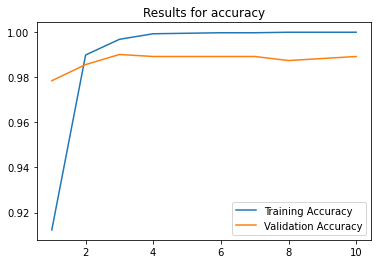

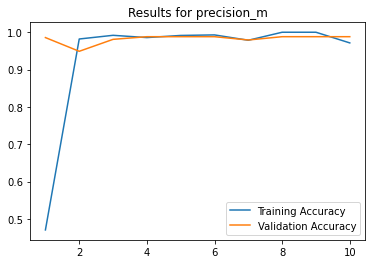

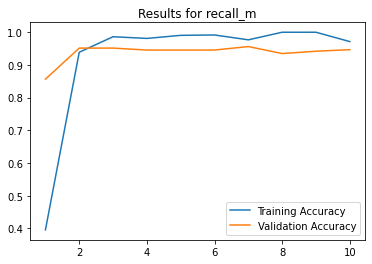

In [23]:
# Plot the evaluation metrics by each epoch for the model to see if we are over or underfitting
import matplotlib.pyplot as plt

for i in ['accuracy', 'precision_m', 'recall_m']:
    acc = history.history[i]
    val_acc = history.history['val_{}'.format(i)]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()